In [35]:
import pandas
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [3]:
train_data=pandas.read_pickle("data/train_data.pkl")
print(train_data.shape)
print(train_data.columns)

(86462, 9)
Index(['business_id', 'name', 'pricerange', 'review_count', 'all_reviews',
       'stars_sum', 'useful_sum', 'funny_sum', 'cool_sum'],
      dtype='object')


In [7]:
val_data=pandas.read_pickle("data/val_data.pkl")
print(val_data.shape)
print(val_data.columns)

(10808, 9)
Index(['business_id', 'name', 'pricerange', 'review_count', 'all_reviews',
       'stars_sum', 'useful_sum', 'funny_sum', 'cool_sum'],
      dtype='object')


In [6]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_df=0.9,min_df=5)

In [8]:
%%time
x_train=tfidf_vectorizer.fit_transform(train_data['all_reviews'])

CPU times: user 5min 16s, sys: 14 s, total: 5min 30s
Wall time: 5min 35s


In [9]:
tfidf_vocab=tfidf_vectorizer.vocabulary_

In [11]:
print(len(tfidf_vocab.keys()))

3062509


In [15]:
print(list(tfidf_vocab.keys())[-5:])

['valleyfield', 'salaberry de', 'de valleyfield', 'valleyfield qu', 'bec canada']


In [16]:
%%time
x_val=tfidf_vectorizer.transform(val_data['all_reviews'])

CPU times: user 41.3 s, sys: 3.62 s, total: 45 s
Wall time: 47.8 s


In [18]:
train_data['pricerange'][:5]

0      2.0
100    3.0
200    1.0
233    2.0
333    3.0
Name: pricerange, dtype: float64

In [22]:
lb=preprocessing.LabelBinarizer()
y_val=lb.fit_transform(val_data['pricerange'])

In [23]:
print(type(y_val))
print(y_val.shape)

<class 'numpy.ndarray'>
(10808, 4)


In [25]:
print(val_data.iloc[0:2]['pricerange'])
print(y_val[0:2,:])

968     4.0
1458    2.0
Name: pricerange, dtype: float64
[[0 0 0 1]
 [0 1 0 0]]


In [26]:
y_train=lb.transform(train_data['pricerange'])

In [27]:
print(x_train.shape)

(86462, 3062509)


In [28]:
%%time
clf=OneVsRestClassifier(LogisticRegression(max_iter=1000)).fit(x_train,y_train)

CPU times: user 39min 20s, sys: 32 s, total: 39min 52s
Wall time: 22min 12s


In [29]:
y_val_predicted_labels=clf.predict(x_val)

In [30]:
y_val_predicted_scores=clf.decision_function(x_val)

In [32]:
def print_evaluation_scores(y_val, predicted):
    acc=accuracy_score(y_val,predicted)
    f1score=f1_score(y_val,predicted,average='weighted')
    pcscore=average_precision_score(y_val,predicted,average='weighted')
    return(round(acc,2),round(f1score,2),round(pcscore,2))

In [33]:
print_evaluation_scores(y_val, y_val_predicted_labels)

(0.68, 0.7, 0.63)

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def roc_auc(y_test, y_score, n_classes):  
    """Plots ROC curve for micro and macro averaging."""
    
    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area     
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes 
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], 
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"], 
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','indigo'])
    for i, color in zip(range(0,n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label='ROC curve of class {0} (area = {1:0.2f})'.format((i+1), roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of ROC to multi-class')
    plt.legend(loc="lower right")
    plt.show()

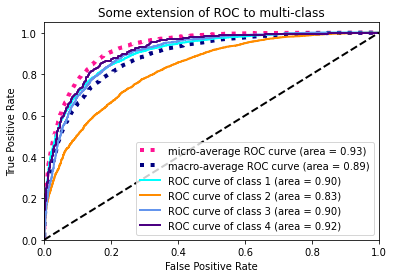

In [47]:
n_classes = 4
roc_auc(y_val, y_val_predicted_scores, n_classes)

In [40]:
from joblib import dump,load

In [42]:
dump(clf,'models/ovrlogreg.joblib')

['models/ovrlogreg.joblib']

In [43]:
dump(tfidf_vectorizer,'models/tfidf_vectorizer.joblib')

['models/tfidf_vectorizer.joblib']

In [48]:
dump(lb,'models/label_binarizer.joblib')

['models/label_binarizer.joblib']